In [144]:
%matplotlib inline
from skimage import io
from skimage.color import rgb2gray
from matplotlib import pyplot as plt, colors
from glob import glob
from skimage.filters import sobel
import numpy as np
from itertools import product
from skimage import img_as_float, img_as_ubyte

import skimage.morphology as mp
from skimage import measure
from skimage.measure import find_contours as fc
from skimage import feature
from skimage import filters


In [145]:
def collage(data, n=7, m=3, width=12, imparams={}):
    sh = data[0].shape
    ratio = sh[0]/sh[1] * n/m
    fig, axes = plt.subplots(n, m,
                             gridspec_kw={"wspace": 0, "hspace": 0})
    fig.set_size_inches(width, width*ratio)
    axes = axes.flatten()
    for i, img in enumerate(data):
        axes[i].axis("off")
        axes[i].imshow(img, aspect='auto', **imparams)
    plt.show()

In [146]:
def collage_fun(data, fun, n=6, m=3, width=12, imparams={}):
    sh = data[0].shape
    ratio = sh[0]/sh[1] * n/m
    fig, axes = plt.subplots(n, m,
                             gridspec_kw={"wspace": 0, "hspace": 0})
    fig.set_size_inches(width, width*ratio)
    axes = axes.flatten()
    for i, img in enumerate(data):
        axes[i].axis("off")
        fun(img, axes[i], aspect='auto', **imparams)
    plt.show()

In [147]:
planes_orig = [io.imread(fn) for fn in sorted(glob("data/samolot??.jpg"))]
planes_bw = [rgb2gray(p) for p in planes_orig]

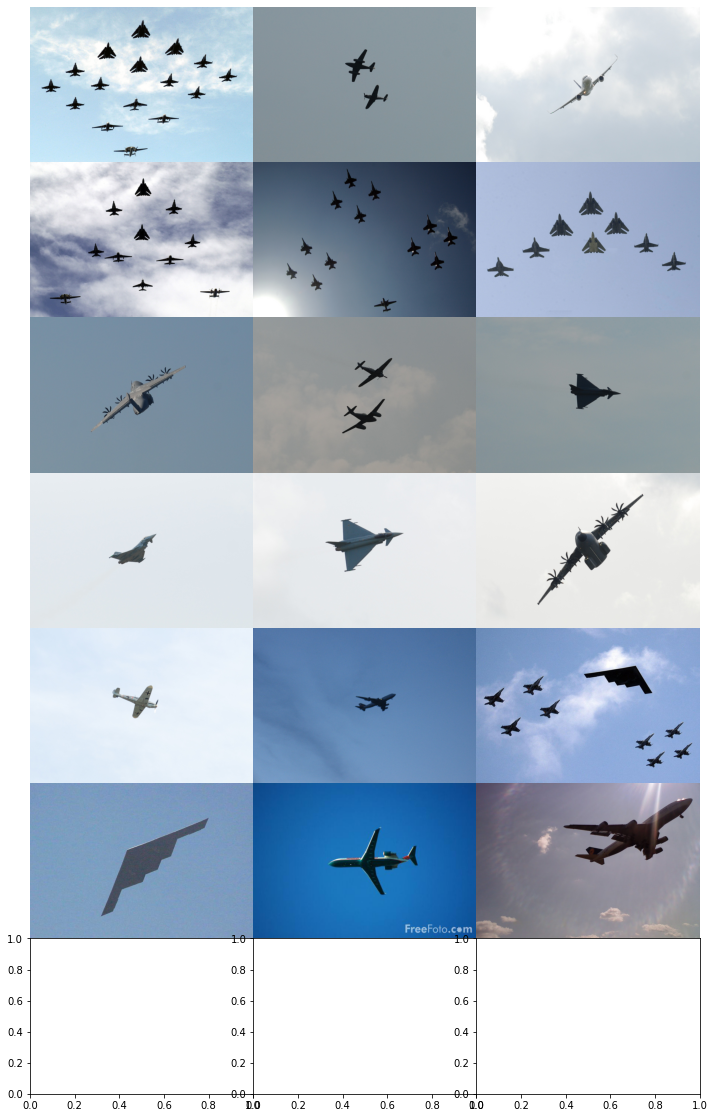

In [148]:
collage(planes_orig)

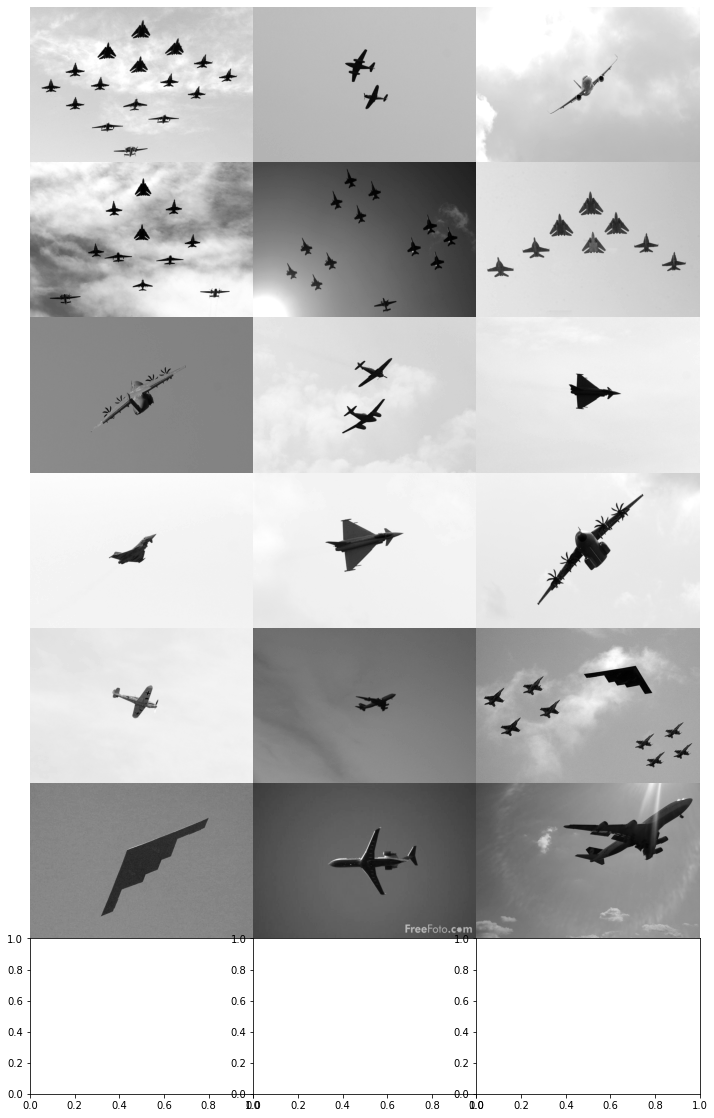

In [149]:
collage(planes_bw, imparams={"cmap": "gray"})

In [150]:
def hist(img, ax=plt, **kwargs):
    h, x = np.histogram(img)
    ax.plot(x[:-1], h, **kwargs)

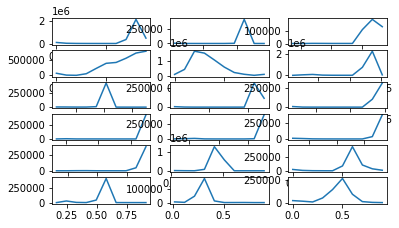

In [151]:
#collage_fun(planes_orig, hist)
for i, p in enumerate(planes_bw):
    plt.subplot(7, 3, i+1)
    hist(p)

In [152]:
from fractions import Fraction
sh = planes_orig[0].shape
print(Fraction(sh[0], sh[1]))
ar = sh[0]/ sh[1]
ar

5/7


0.7142857142857143

In [153]:
def bbox(c):
    diag = *np.min(c, 0), *np.max(c, 0)
    return list(product(diag[::2], diag[1::2]))

def bboxwh(bb):
    return bb[3][0]-bb[0][0], bb[3][1]-bb[0][1]

def in_bbox(p, diag, sl=0):
    return diag[0][0]-sl < p[0] < diag[1][0]+sl and \
            diag[0][1]-sl < p[1] < diag[1][1]+sl

def bboxcr(bb):
    a, b = bboxwh(bb)
    r = min(a, b)/2
    ctr = ((bb[0][0]+bb[3][0])/2, (bb[0][1]+bb[3][1])/2)
    return ctr, r

# slack percent
def circ_int(bb1, bb2, slp=0):
    c1, r1 = bboxcr(bb1)
    c2, r2 = bboxcr(bb2)
    sl = max(r1, r2)*slp
    ret = (c2[0]-c1[0])**2+(c2[1]-c1[1])**2 < (r1+r2+sl)**2
    #print(c1, r1, "|", c2, r2, "|", (c2[0]-c1[0])**2+(c2[1]-c1[1])**2, "|", (r1+r2+sl)**2, "|", ret)
    return ret

def intersect(bb1, bb2, slack=0):
    d1 = [bb1[0], bb1[3]]
    d2 = [bb2[0], bb2[3]]
    return any(in_bbox(p, d2, slack) for p in bb1) or \
            any(in_bbox(p, d1, slack) for p in bb2)


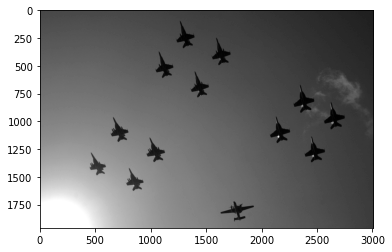

In [154]:
planes = planes_bw.copy()
pp1 = planes[4]
plt.imshow(pp1, cmap='gray')

In [195]:
from matplotlib import patches
from random import random as rr
pc = 0

def bboxr(bb):
    _, r = bboxcr(bb)
    return r

def plot_cont(bw_pic, col_pic=None, ax=plt):
    
#     if (bw_pic.std() <= 0.046):
    img = img_as_float(bw_pic)
    MIN = bw_pic.mean() - bw_pic.std()
    MAX = bw_pic.mean() + bw_pic.std()
    norm = (img - MIN) / (MAX - MIN)
    norm[norm > 1] = 1
    norm[norm < 0] = 0
    bw_pic = norm
    
    
    global pc
    sh = bw_pic.shape
    pp = bw_pic.copy()
    
    pp = pp.clip(0, np.percentile(pp, 70))
    ppx = pp.copy()

    print(pc)
    pc += 1
    
    pp = feature.canny(pp, sigma=3)
    pp = (pp > 0.7)*1.0
    
    # remove caption?
    #pp[int(sh[0]*0.9):,:] = 0
    
    pp = mp.dilation(pp)
    
    #pp = mp.erosion(pp)

    
    ax.imshow(ppx, cmap='gray', aspect='auto') if col_pic is None else ax.imshow(col_pic, aspect='auto')
    
    
    slack = 0.4
    if True:
        
        cs = fc(pp, level=0.8)
        
        cs.sort(key=lambda x:bboxr(bbox(x)), reverse=True)
        
        if True:
            cs2 = []
            bboxes = []
            for j, c in enumerate(cs):
                bb = bbox(c)
                wh = bboxwh(bb)
                rect = patches.Rectangle((bb[0][1], bb[0][0]), \
                                         wh[1], wh[0], facecolor='none',
                                        edgecolor='g')
                ctr, r = bboxcr(bb)
                circ = patches.Circle((ctr[1], ctr[0]), r, \
                                      facecolor='none', edgecolor='r')
                if ax is not plt and False:
                    ax.add_patch(circ)
                    ax.add_patch(rect)
                for i, (c1, bb1) in enumerate(zip(cs2, bboxes)):
                    if circ_int(bb, bb1, slack) or intersect(bb, bb1, 0):
                        c1 = cs2[i] = np.append(c1, c, 0)
                        bboxes[i] = bbox(cs2[i])
                        break
                else:
                    cs2.append(c)
                    bboxes.append(bbox(c))
        else:
            cs2 = cs
        last_h = 0
        for c in cs2:
            ctr = np.mean(c, 0)
            hsv = (last_h, 1, 1)
            last_h = (last_h+0.15)%1
            col = [[*colors.hsv_to_rgb(hsv)]]
            ax.scatter(c[:,1], c[:,0], [1]*len(c), c=col)
            ax.scatter([ctr[1]], [ctr[0]], c='w')
    else:
        ax.imshow(pp, cmap='gray')
    #w = 8
    #ax.figure(figsize=(w, w/ar))
    
    

In [196]:
# # def plot_hist(img):
# #     img = img_as_ubyte(img)
# #     histo, x = np.histogram(img, range(0, 256), density=True)
# #     plt.plot(histo)

# pi = 6
# fw = 20
# fig, ax = plt.subplots()
# fig.set_size_inches((fw, fw*ar))
# img = img_as_float(planes_bw[pi])
# MIN = 130 / 256
# MAX = 145 / 256

# # MIN = np.percentile(img,40)

# # MAX = np.percentile(img,70)
# norm = (img - MIN) / (MAX - MIN)
# norm[norm > 1] = 1
# norm[norm < 0] = 0
# planes_bw[pi] = norm
# # print(planes_bw[pi].std());
# plot_cont( norm, planes_orig[pi], ax)
print(planes_bw[pi].std())


0.04594027704744622


In [197]:
def collage2(data_gen, n=7, m=3, width=12, imparams={}, fr=0):
    global pc
    fig, axes = plt.subplots(n, m,
                             gridspec_kw={"wspace": 0, "hspace": 0})
    fig.set_size_inches(width, width*ar*n/m)
    axes = axes.flatten()
    for i in range(fr, n*m):
        pc = i
        axes[i].axis("off")
        data_gen(i, axes[i])
        #axes[i].imshow(img, aspect='auto', **imparams)
    plt.show()

In [198]:
def planes_gen(i, ax):
    plot_cont(planes_bw[i], planes_orig[i], ax)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


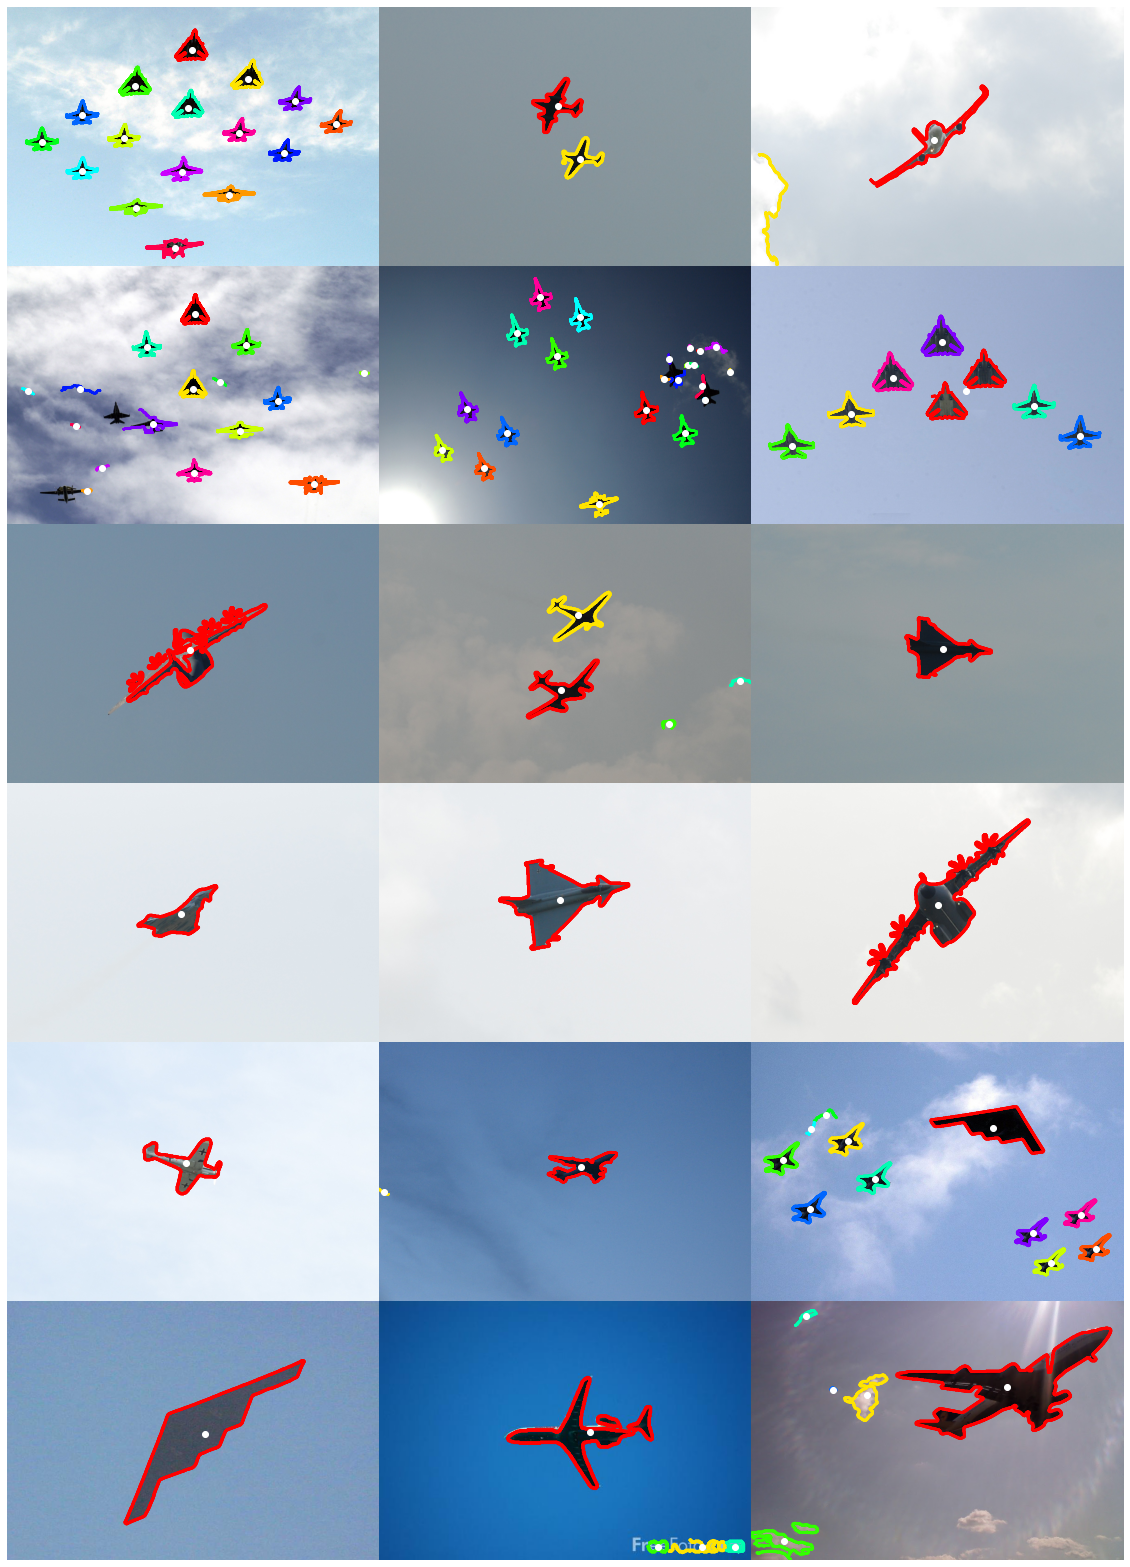

In [199]:
collage2(planes_gen, 6, fr=0, width=20)